In [40]:
%matplotlib inline
from ecell4 import *
import numpy as np
import math
import matplotlib.pyplot as plt

k_factor = 1
voxelr = 0.005  
L = 200*voxelr
print 'L',L
D = 1
kd= 4.0*math.pi*D*2*voxelr
ka = k_factor*kd
kon = (ka*kd)/(ka+kd)
kr = 0.01
koff = kd*kr/(kd+ka)
tm =(2*voxelr)**2/(6*D)
N = 1000
duration = 1#tm*7000#0.1
dt=tm
w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
Vr = w.calculate_volume(ones()*L,voxelr)
lx,ly,lz = tuple(w.calculate_shape(ones()*L,voxelr))
Nv = lx*ly*lz
vv = w.calculate_voxel_volume(voxelr)
phi = 2.*N/Nv
r0=0.256318
Pacc= (1./r0-1)*ka/kd
kdd = 3*(2**0.5)*D*2*voxelr*(1/r0 -1)
kefftheory = kdd*Pacc/(Pacc+1/r0 -1)
print 'Vr',Vr
print ka,kd,kon
print 'phi',phi*100,'phir',2*N*100*vv/Vr
print kefftheory

L 1.0
Vr 1.03744444194
0.125663706144 0.125663706144 0.0628318530718
phi 0.136317040721 phir 0.136317040721
0.0615480674685


0.0178618662047


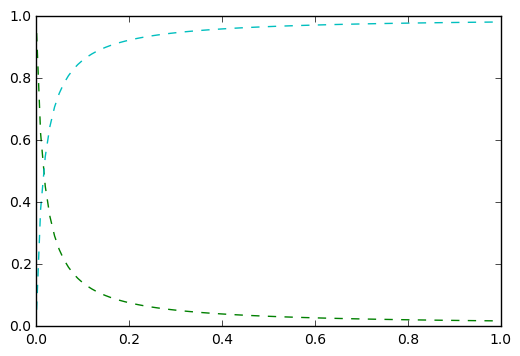

In [2]:
with reaction_rules():#for ODE
    A +B == C | (kon,koff)

m1 = get_model()

ode = np.array(run_simulation(duration, model=m1, y0={'A': N,'B': N,'C':0}, solver='ode', volume=Vr, return_type='array'))
to = ode[:,0]
nao = ode[:,1]
nco = ode[:,3]
print nao[-1]/N
plt.plot(to,nao/N,'g--')
plt.plot(to,nco/N,'c--')

In [3]:
with species_attributes():
    A |  {'D': str(0), 'radius':str(voxelr)}
    B |  {'D': str(D), 'radius':str(voxelr)}
    C |  {'D': str(0), 'radius':str(voxelr)}

with reaction_rules():#for spa and egfrd
    A + B == C | (ka,kr)

m2 = get_model()

def singlerun(i):
    rng = GSLRandomNumberGenerator()
    rng.seed(i)
    #w = spatiocyte.create_spatiocyte_world_cell_list_impl(ones() * L, voxelr, Integer3(3, 3, 3), rng)
    w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr,rng)
    w.bind_to(m2)
    #ll= tuple(w.actual_lengths())
    #print ll[0]*ll[1]*ll[2]
    w.add_molecules(Species('A'), N)
    w.add_molecules(Species('B'), N)
    w.add_molecules(Species('C'), 0)
    #obs = FixedIntervalNumberObserver(dt, ('A'))
    sim = spatiocyte.SpatiocyteSimulator(w)
    sim.initialize()
    #sim.run(duration, obs)    
    tlog=dt
    tlogs=[]
    nlogA=[]
    nlogC=[]
    while sim.t()<duration:
        if sim.t()>tlog:
            tlogs.append(tlog)
            nlogA.append(w.num_particles_exact(Species('A')))
            nlogC.append(w.num_particles_exact(Species('C')))
            tlog+=dt
        sim.step()
    return np.array(tlogs),np.array(nlogA),np.array(nlogC)



In [4]:
def runspa(run):   
    leng = int((duration/dt)-1)
    na = np.empty([run,leng])
    nc = np.empty([run,leng])
    for i in range(run):
        t,Na,Nc = singlerun(i)
        na[i] = Na        
        nc[i] = Nc        
    return t,na,nc


In [5]:
run = 10
#te,nae = rungtest(run)
#print len(te)
ts,nas,ncs = runspa(run)


In [6]:
meana = np.mean(nas,axis=0)
meanc = np.mean(ncs,axis=0)
#std = np.std(nas,axis=0)

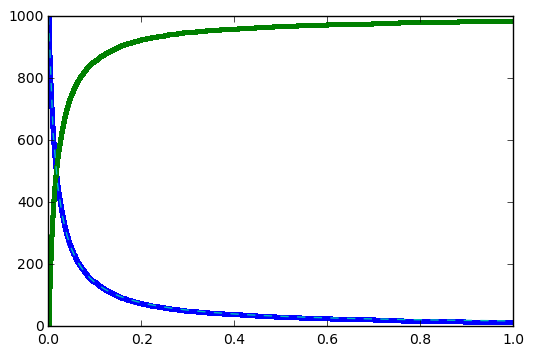

In [7]:
plt.plot(ts,meana,'b.-')
plt.plot(ts,meanc,'g.-')
#plt.plot(ts,meanc+meana,'g.-')
plt.plot(to,nao,'c--')


0.125663706144 0.0628318530718
[  1.66666667e-05   3.33333333e-05   5.00000000e-05   6.66666667e-05
   8.33333333e-05]


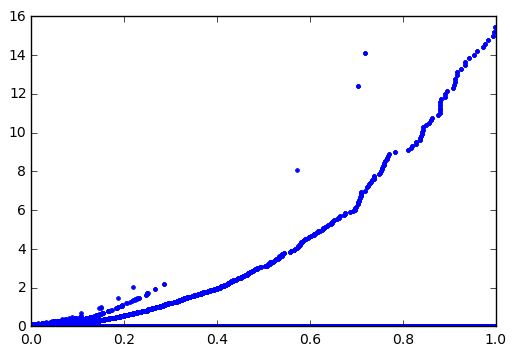

In [47]:
def getkt2(st,t): #two-point
    ks = -Vr *(st[2:]-st[:-2])/st[:-2]/(t[2]-t[0])/st[:-2]
    return ks

ra = getkt2(meana,ts)
ks = kr*Vr*meanc[:-2]/meana[:-2]/meana[:-2]+ra
plt.plot(ts[1:-1],ra,'.')
print ka,kon
print ts[:5]

In [52]:
#ecell3 N1000, original P=0.1,run=1e4 A+B==C
import numpy as np
import math
dat = np.loadtxt('/home/chew/wrk/spatiocyte/examples/accuracy/3D_reaction/spatiocyte_3D_Rkeff_N1k_P1.csv',delimiter=',',skiprows=1)
tc=dat[:,0]
nsa=dat[:,1]
nsc=dat[:,2]

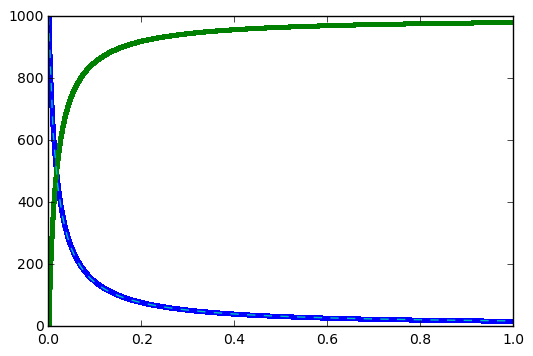

In [53]:
plt.plot(tc,nsa,'b.-')
plt.plot(tc,nsc,'g.-')
plt.plot(to,nao,'c--')


0.125663706144 0.0628318530718
0.0374341758264


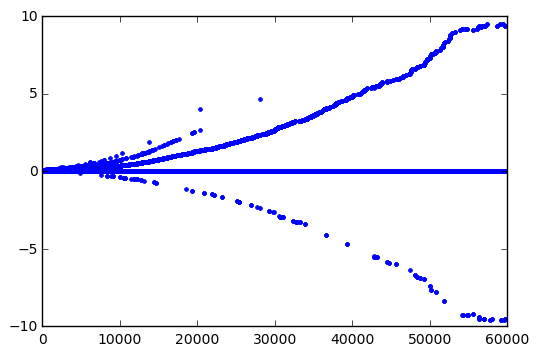

In [61]:
def getkt2(st,t): #two-point
    ks = -Vr *(st[2:]-st[:-2])/st[:-2]/(t[2]-t[0])/st[:-2]
    return ks

ra = getkt2(mnac,tc)
ks = kr*Vr*nsc[:-2]/nsa[:-2]/nsa[:-2]+ra
#plt.plot(tc[1:-1],ks,'.')
#plt.plot(ra)
plt.plot(ra,'.')
print ka,kon
print np.mean(ks[54000:])